In [4]:
import sys
!{sys.executable} -m pip install python-Levenshtein

In [12]:
import pandas as pd
import numpy as np
import time
from fuzzywuzzy import fuzz,process
import random
from datetime import datetime
import matplotlib.pyplot as plt

##### Testing Fuzzy wuzzy

In [95]:
# Source :https://www.datacamp.com/community/tutorials/fuzzy-string-python



# Test strings
str1 = "apple Inc."
str2 = "Apple"
str3 = "ogle Inc.."
str4 = 'Dollar tree'
str5 = 'family dollar'
str6= 'DRIS STRAWBRY'
str7= 'DIRS STRAWBRY'
str8='PUBLIX GRK 0%PLAIN'
str9='PUBLIX GRK PLAIN'
str10='SKINNYPOP POIPCORN 10Z'
str11='SKINNYPOP POPCORN 10Z'
str12='SKINNYPOP WHT CHEDRA POPCORN'
str13='FD RUSSEL POTATOES'
str14='POATOED RUSSED'
# Comparison strings
first=str13
second=str14

# API
Ratio = fuzz.ratio(first.lower(),second.lower())
pRatio = fuzz.partial_ratio(first.lower(),second.lower())
tRatio = fuzz.token_sort_ratio(first.lower(),second.lower())
tsRatio = fuzz.token_set_ratio(first.lower(),second.lower())
print("comparing strings","\n",first,"\n",second)
print("\nBelow are various ratio metrics, Closer to 100, better is the identification of the match\n")
print("levinstein:",Ratio," partial fuzzy:",pRatio," partial and sort fuzzy:",tRatio," combination of 2nd and 3rd:",tsRatio)

comparing strings 
 FD RUSSEL POTATOES 
 POATOED RUSSED

Below are various ratio metrics, Closer to 100, better is the identification of the match

levinstein: 44  partial fuzzy: 50  partial and sort fuzzy: 75  combination of 2nd and 3rd: 75


The trick is not getting too wild in the match where "Apple inc." gets mapped to "google inc." nor narrow where "apple" and "aple" does not map 

the assumption we are making here is whatever we have in our system is the source of truth and nothing else. We can probably create the algo in such a way that it priorities a retailer name first before a generic name

In [14]:
# ----------NA tables
# --- All
na_rsd_wtbanner=pd.read_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/input to python/_vkumar_NaAttrib_narsds__with_bannerid2.csv')
# ---- Pre
na_rsd_wtbanner_pre=pd.read_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/input to python/_vkumar_NaAttrib_narsds__with_bannerid_pre.csv')
# ---- Post
na_rsd_wtbanner_post=pd.read_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/input to python/_vkumar_NaAttrib_narsds__withbannerid_post.csv')

#-----------30 million rows table , do not pull unless required
# orig_rsd=pd.read_csv('/Users/varun.kumar/Documents/varun/numerator/attribution analysis/data/_vkumar_NaAttrib_origrsds__201909121245.csv')
 
# ------------ Mapped tables
# orig_rsd_notgeneric=pd.read_csv('/Users/varun.kumar/Documents/varun/numerator/attribution analysis/data/_vkumar_NaAttrib_origrsds__notgeneric.csv')
# orig_rsd_wtsecgrocery=pd.read_csv('/Users/varun.kumar/Documents/varun/numerator/attribution analysis/data/_vkumar_NaAttrib_origrsds__withsectorgrocery.csv')
# orig_rsd_wtbanner=orig_rsd_wtsecgrocery[orig_rsd_wtsecgrocery['CNT']>1][['RSD','BANNER_GROUP']]
orig_rsd_wtalinper=pd.read_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/input to python/_vkumar_NaAttrib_origrsds_denorm__w_all_rsd_in_period.csv')
orig_rsd_wtal_banner=orig_rsd_wtalinper[['RSD','BANNER_ID']]


In [ ]:
# testing for multiple hierarchy mapping for the same RSD
orig_rsd['flag']=np.where(orig_rsd['HIGHEST_HIERARCHY']==orig_rsd['LOWEST_HIERARCHY'], 1,0)
print(len(orig_rsd),orig_rsd['flag'].sum())

In [90]:
print(orig_rsd_wtal_banner.columns,
na_rsd_wtbanner.columns)

Index(['RSD', 'BANNER_ID'], dtype='object') Index(['RSD', 'BANNER_ID'], dtype='object')


In [105]:
na_rsd_wtbanner.head()
# orig_rsd_wtbanner.head()

,RSD,BANNER_ID
0,FAUX SNOW ASTD,dollar_tree
1,PUBLIX PREM LE QT,publix
2,CRUNCHY RICE ROLLS,aldi
3,H/C S/S SPN/TM LNG,publix
4,ROSTED BAKER W LID PK,dollar_tree


In [53]:
print(len(na_rsd),len(na_rsd_wtbanner),len(orig_rsd_wtbanner))

1259330 1263581 657219


### Mapped RSDs

In [6]:
orig_rsd_wtal_banner.groupby('BANNER_ID').count() 

,RSD
BANNER_ID,
aldi,152794
dollar_tree,173377
food_lion,327554
kroger,492913
publix,388219
sams_club,22106
shop_rite,558090


### NA RSDs

In [7]:
na_rsd_wtbanner_pre.groupby('BANNER_ID').count()

,RSD
BANNER_ID,
aldi,44227
dollar_tree,28367
food_lion,31320
kroger,74833
publix,54123
sams_club,613
shop_rite,71062


### Filter for Text matching 

In [15]:
# -------- Mapped RSDs

## ---- data master
# orig_rsd_wtbanner_sams=orig_rsd_wtbanner[orig_rsd_wtbanner['BANNER_GROUP']=='sams_club']
# orig_rsd_wtbanner_generic=orig_rsd_wtbanner[orig_rsd_wtbanner['BANNER_GROUP']=='generic']

# ----- with banners & Generic
# orig_rsd_wtbanner_gsams=orig_rsd_wtbanner[orig_rsd_wtbanner['BANNER_GROUP'].isin(['sams_club','generic'])]


## ---- denorm i.e. from respective mapped banner instead of generic
orig_rsd_wtal_banner_publix=orig_rsd_wtal_banner[orig_rsd_wtal_banner['BANNER_ID']=='publix']





# -------- NA RSDs
# -- all
na_rsd_wtbanner_sams=na_rsd_wtbanner[na_rsd_wtbanner['BANNER_ID']=='sams_club'] 
na_rsd_wtbanner_publix=na_rsd_wtbanner[na_rsd_wtbanner['BANNER_ID']=='publix'] 
na_rsd_wtbanner_shop_rite=na_rsd_wtbanner[na_rsd_wtbanner['BANNER_ID']=='shop_rite'] 
na_rsd_wtbanner_aldi=na_rsd_wtbanner[na_rsd_wtbanner['BANNER_ID']=='aldi'] 
na_rsd_wtbanner_food_lion=na_rsd_wtbanner[na_rsd_wtbanner['BANNER_ID']=='food_lion'] 
na_rsd_wtbanner_dollar_tree=na_rsd_wtbanner[na_rsd_wtbanner['BANNER_ID']=='dollar_tree'] 
na_rsd_wtbanner_kroger=na_rsd_wtbanner[na_rsd_wtbanner['BANNER_ID']=='kroger'] 
# -- pre
na_rsd_wtbanner_pre_publix=na_rsd_wtbanner_pre[na_rsd_wtbanner_pre['BANNER_ID']=='publix'] #191914
# -- post
na_rsd_wtbanner_post_publix=na_rsd_wtbanner_post[na_rsd_wtbanner_post['BANNER_ID']=='publix'] #54123

In [92]:
na_rsd_wtbanner_sams

,RSD,BANNER_ID
110,MMMALBEC750,sams_club
525,HZLNT PUMP,sams_club
703,CTCOZYTOP,sams_club
1009,FRENCH FRY F,sams_club
1286,MM HALF PAN,sams_club
1469,HF SMC SGE F,sams_club
1944,GAIM HE LIQ,sams_club
3192,SMKEDTURKEYF,sams_club
3477,NAANDIPPERSF,sams_club
4137,MEDJOO DATE,sams_club


### Test runs

#### Iterrows 
is 5x slower than iloc

In [145]:
%%timeit

mx=1

for indexna, rowna in na_rsd_wtbanner_sams.iterrows():
    for indexo, rowo in orig_rsd_wtbanner_sams.iterrows():
        ld=fuzz.ratio(str(rowo['RSD']),str(rowna['RSD']))
        if ld>mx:
                mx=ld
                row_orig=indexo
                row_na=indexna

print(mx)

69
69
69
69
69
69
69
69
3.41 s ± 37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### iloc

BASIC

In [194]:
# function for iter rows - levinshtein distance
def iloc_lv_v1(mapped_RSDs,NA_RSDs):
    mx=1
    randmapped=random.randint(int(len(mapped_RSDs)*0.99),len(mapped_RSDs))
    print("Chosen random:",randmapped)
    print('samples from mapped:',len(mapped_RSDs)-randmapped,'samples from NAs:',len(NA_RSDs),"loops run",":",(len(mapped_RSDs)-randmapped)*len(NA_RSDs))
    for j in range(len(NA_RSDs)):
        for i in range(randmapped,len(mapped_RSDs)):
            ld=fuzz.ratio(str(NA_RSDs.iloc[j,0]),str(mapped_RSDs.iloc[i,0]))
            if ld>mx:
                    mx=ld
                    row_orig=i
                    row_na=j
    
    print("levenshtein:",mx,"|",NA_RSDs.iloc[row_na,0],"|",mapped_RSDs.iloc[row_orig,0])

iloc_lv_v1(orig_rsd_wtbanner_generic,na_rsd_wtbanner_sams)

Chosen random: 647347
samples from mapped: 2473 samples from NAs: 2549 loops run : 6303677
levinstein: 89 | TURKEY F | TURKEY 0 F


INCLUDING SAMPLING FOR NA RSDs

In [223]:
# function for iter rows - levenshtein distance
def iloc_lv_v2(mapped_RSDs,NA_RSDs,samplePercentM,samplePercentN):
    #initialization
    maxDistance=1
    mappedRsdSize=len(mapped_RSDs)
    naRsdSize=len(NA_RSDs)
    
    #  --- Setting the range for mapped RSDs
    randSeedMapped=random.randint(1,100-(samplePercentM+1))
#     print(randSeedMapped)
    minMapped=int(mappedRsdSize*(randSeedMapped/100))
    maxMapped=minMapped+int((samplePercentM/100)*mappedRsdSize)
    
    #  --- Setting the range for NA RSDs    
    randSeedNa=random.randint(1,100-(samplePercentN+1))
#     print(randSeedNa)
    minNa=int(naRsdSize*(randSeedNa/100))
    maxNa=minNa+int((samplePercentN/100)*naRsdSize)
    

    print("Chosen random range of NA RSDs:",randSeedNa,"% - ",randSeedNa+samplePercentN,"% |",minNa,"-",maxNa)
    print("Chosen random range of mapped RSDs:",randSeedMapped,"% - ",randSeedMapped+samplePercentM,"% |",minMapped,"-",maxMapped)
    print('# samples from mapped:',maxMapped-minMapped,'samples from NAs:',maxNa-minNa,"loops run",":",(maxNa-minNa)*(maxMapped-minMapped))
    for j in range(minNa,maxNa):
        for i in range(minMapped,maxMapped):
#             print(i)
            ld=fuzz.ratio(str(NA_RSDs.iloc[j,0]),str(mapped_RSDs.iloc[i,0]))
            if ld>maxDistance:
                    maxDistance=ld
                    row_orig=i
                    row_na=j
    
    print("levenshtein:",maxDistance,"|",NA_RSDs.iloc[row_na,0]," ; pos:",row_na,"|",mapped_RSDs.iloc[row_orig,0]," ; pos:",row_orig)
     

PASSING NA AND MAPPED RSDS AS NUMPY VALUES INSTEAD OF PANDAS SERIES : Reduces the time by 4x

In [229]:
def iloc_lv_v3(mapped_RSDs,NA_RSDs,samplePercentM,samplePercentN):
    #initialization
    maxDistance=1
    mappedRsdSize=len(mapped_RSDs)
    naRsdSize=len(NA_RSDs)

    
    #  --- Setting the range for mapped RSDs
    randSeedMapped=random.randint(1,100-(samplePercentM+1))
#     print(randSeedMapped)
    minMapped=int(mappedRsdSize*(randSeedMapped/100))
    maxMapped=minMapped+int((samplePercentM/100)*mappedRsdSize)
    
    #  --- Setting the range for NA RSDs    
    randSeedNa=random.randint(1,100-(samplePercentN+1))
#     print(randSeedNa)
    minNa=int(naRsdSize*(randSeedNa/100))
    maxNa=minNa+int((samplePercentN/100)*naRsdSize)
    

    print("Chosen random range of NA RSDs:",randSeedNa,"% - ",randSeedNa+samplePercentN,"% |",minNa,"-",maxNa)
    print("Chosen random range of mapped RSDs:",randSeedMapped,"% - ",randSeedMapped+samplePercentM,"% |",minMapped,"-",maxMapped)
    print('# samples from mapped:',maxMapped-minMapped,'samples from NAs:',maxNa-minNa,"loops run",":",(maxNa-minNa)*(maxMapped-minMapped))
    NA_array=NA_RSDs['RSD'].values
    mapped_array=mapped_RSDs['RSD'].values
    for j in range(minNa,maxNa):
        for i in range(minMapped,maxMapped):
#             print(i)
            ld=fuzz.ratio(str(NA_array[j]),str(mapped_array[i]))
            if ld>maxDistance:
                    maxDistance=ld
                    row_orig=i
                    row_na=j
    
    print("levenshtein:",maxDistance,"|",NA_RSDs.iloc[row_na,0]," ; pos:",row_na,"|",mapped_RSDs.iloc[row_orig,0]," ; pos:",row_orig)

OLD LOGIC WAS SIMPLY SPITTING OUT THE HIGHEST MATCH SCORE OF THE WHOLE SAMPLE OF NA  
CHANGED ALGORITHM TO STORE THE HIGHEST(MATCH_SCORE) MAPPING AGAINST EACH NA RSD IN THE SAMPLE 

In [22]:
def iloc_lv_v4(mapped_RSDs,NA_RSDs,samplePercentM,samplePercentN):
    #initialization
    maxDistance=1
    mappedRsdSize=len(mapped_RSDs)
    naRsdSize=len(NA_RSDs) 
    
    #  --- Setting the range for mapped RSDs
    randSeedMapped=random.randint(1,100-(samplePercentM+1))
#     print(randSeedMapped)
    minMapped=int(mappedRsdSize*(randSeedMapped/100))
    maxMapped=minMapped+int((samplePercentM/100)*mappedRsdSize)
    
    #  --- Setting the range for NA RSDs    
    randSeedNa=random.randint(1,100-(samplePercentN+1))
#     print(randSeedNa)
    minNa=int(naRsdSize*(randSeedNa/100))
    maxNa=minNa+int((samplePercentN/100)*naRsdSize)
    

    print("Chosen random range of NA RSDs:",randSeedNa,"% - ",randSeedNa+samplePercentN,"% |",minNa,"-",maxNa)
    print("Chosen random range of mapped RSDs:",randSeedMapped,"% - ",randSeedMapped+samplePercentM,"% |",minMapped,"-",maxMapped)
    print('# samples from mapped:',maxMapped-minMapped,'samples from NAs:',maxNa-minNa,"loops run",":",(maxNa-minNa)*(maxMapped-minMapped))
    
    
    mapped_array=mapped_RSDs['RSD'][minMapped:maxMapped].astype(str).values
#     print(mapped_array[1:10])
    def match(NA):
#         NA_array=(x['RSD'].values).astype(str)
        match = process.extractOne(str(NA['RSD']), mapped_array, scorer=fuzz.ratio)
        return pd.Series([match[0], match[1]])   
    
    NA_RSDs_limit=NA_RSDs.iloc[minNa:maxNa,:]
    NA_RSDs_limit[['match_term','match_score']] = NA_RSDs_limit.apply(match, axis=1, result_type='expand')
    return NA_RSDs_limit

CHANGE FROM THE V4 LOGIC: CHANGED THE NUMPY ARRAY TO LIST COMPREHENSION AS LISTS ARE FASTER IN PYTHON LOOPING

In [51]:
def iloc_lv_v5(mapped_RSDs,NA_RSDs,samplePercentM,samplePercentN):
    #initialization
    maxDistance=1
    mappedRsdSize=len(mapped_RSDs)
    naRsdSize=len(NA_RSDs) 
    
    #  --- Setting the range for mapped RSDs
    randSeedMapped=random.randint(1,100-(samplePercentM+1))
#     print(randSeedMapped)
    minMapped=int(mappedRsdSize*(randSeedMapped/100))
    maxMapped=minMapped+int((samplePercentM/100)*mappedRsdSize)
    
    #  --- Setting the range for NA RSDs    
    randSeedNa=random.randint(1,100-(samplePercentN+1))
#     print(randSeedNa)
    minNa=int(naRsdSize*(randSeedNa/100))
    maxNa=minNa+int((samplePercentN/100)*naRsdSize)
    

    print("Chosen random range of NA RSDs:",randSeedNa,"% - ",randSeedNa+samplePercentN,"% |",minNa,"-",maxNa)
    print("Chosen random range of mapped RSDs:",randSeedMapped,"% - ",randSeedMapped+samplePercentM,"% |",minMapped,"-",maxMapped)
    print('# samples from mapped:',maxMapped-minMapped,'| samples from NAs:',maxNa-minNa,"| loops run",":",(maxNa-minNa)*(maxMapped-minMapped),"| Est Time",(maxNa-minNa)*(maxMapped-minMapped)*4.7/(1000000*60)," min")
    
    
    mappedlist=list(mapped_RSDs['RSD'][minMapped:maxMapped].astype(str).values)
    NAlist=list(NA_RSDs['RSD'][minNa:maxNa].astype(str).values)

    def match(NA):
#         NA_array=(x['RSD'].values).astype(str)
        match = process.extractOne(NA, mappedlist, scorer=fuzz.ratio)
        return list(match)   
    
    matchlist=[match(rsd) for rsd in NAlist]
    match_final= pd.concat([pd.DataFrame(NAlist,columns=['NA_RSDs']),pd.DataFrame(matchlist,columns=['match_term','match_score'])],axis=1)    

    return match_final

Repeated resampling and comparing with NA RSDs feature is included

### Final Algorithm

Algorithm description: Compares the unattributed (NA) RSDs with mapped(ones having categories mapped) RSDs of the respective banners through a text matching technique. The algo picks a sample set of NA RSDs of a banner and matches with mapped RSDs by repeated re-Sampling. The algo compares the champion score with a challenger score for every mapped sample. The sample sizes and number of resampling can be specified.

Observations: The extraction of matches is optimized. List looping is fastest compared to numpy and pandas.

Time: 5 seconds per million iterations

In [38]:
def iloc_lv_v6(mapped_RSDs,NA_RSDs,samplePercentM,samplePercentN,nResample,levenshteinyes):
    #initialization
    
    if levenshteinyes:
        method=fuzz.ratio
    else:
        method=fuzz.token_set_ratio
        
    def match(NA):
        match = process.extractOne(NA, mappedlist, scorer=method)
        return list(match)     
    
    
    mappedRsdSize=len(mapped_RSDs)
    naRsdSize=len(NA_RSDs) 
    
        #  --- Setting the range for NA RSDs    
    randSeedNa=random.randint(1,100-(samplePercentN+1)) # seeding
        # ranging 
    minNa=int(naRsdSize*(randSeedNa/100))
    maxNa=minNa+int((samplePercentN/100)*naRsdSize)

    startTime = time.time()
    
    for s in range(nResample):
        loop_start_time=time.time()
        print("--- %s seconds ---" % (time.time() - startTime),"\n\n\n","Iterations left:",nResample-s)
        #  --- Setting the range for mapped RSDs
        randSeedMapped=random.randint(1,100-(samplePercentM+1)) #Seeding
            # ranging 
        minMapped=int(mappedRsdSize*(randSeedMapped/100))
        maxMapped=minMapped+int((samplePercentM/100)*mappedRsdSize)


        print("Chosen random range of NA RSDs:",randSeedNa,"% - ",randSeedNa+samplePercentN,"% |",minNa,"-",maxNa)
        print("Chosen random range of mapped RSDs:",randSeedMapped,"% - ",randSeedMapped+samplePercentM,"% |",minMapped,"-",maxMapped)
        print('# samples from mapped:',maxMapped-minMapped,'samples from NAs:',maxNa-minNa,"loops run",":",(maxNa-minNa)*(maxMapped-minMapped),"Est time:",(maxNa-minNa)*(maxMapped-minMapped)*5/(1000000)," sec \n\n\n")


        mappedlist=list(mapped_RSDs['RSD'][minMapped:maxMapped].astype(str).values)
        NAlist=list(NA_RSDs['RSD'][minNa:maxNa].astype(str).values)


        
        if (s == 0):
            matchlist=[match(rsd) for rsd in NAlist]  
            match_final= pd.concat([pd.DataFrame(NAlist,columns=['NA_RSDs']),pd.DataFrame(matchlist,columns=['match_term','match_score'])],axis=1)    
        else:
            challengerList=[match(rsd) for rsd in NAlist]  
            match_final= pd.concat([pd.DataFrame(NAlist,columns=['NA_RSDs']),pd.DataFrame(matchlist,columns=['match_term','match_score']),pd.DataFrame(challengerList,columns=['cMatch_term','cMatch_score'])],axis=1)    
            # Step to compare champion and challenger
            (match_final['match_term'],match_final['match_score'])=np.where(match_final['match_score']> match_final['cMatch_score'] , (match_final['match_term'],match_final['match_score']), (match_final['cMatch_term'],match_final['cMatch_score']))
            curr_time=time.time()
            loop_time=curr_time-loop_start_time
            print('loop_time: %s seconds' % loop_time)

    return match_final

In [39]:
print(datetime.now())
    

    #Timing the algorithm
startTime = time.time()


#     iloc_lv_v6(mapped_RSDs,NA_RSDs,samplePercentMapped,samplePercentNA,number of Resampling,levenshteinYes?)
match=iloc_lv_v6(orig_rsd_wtal_banner_publix,na_rsd_wtbanner_publix,20,2,4,True)

print("--- %s seconds ---" % (time.time() - startTime),"\n\n\n")
    

2019-10-07 14:13:24.828630
--- 1.9073486328125e-06 seconds --- 


 Iterations left: 4
Chosen random range of NA RSDs: 29 % -  31 % | 67287 - 71927
Chosen random range of mapped RSDs: 26 % -  46 % | 100937 - 178581
# samples from mapped: 77644 samples from NAs: 4640 loops run : 360268160 Est time: 1801.3408  sec 



--- 1810.3085918426514 seconds --- 


 Iterations left: 3
Chosen random range of NA RSDs: 29 % -  31 % | 67287 - 71927
Chosen random range of mapped RSDs: 52 % -  72 % | 201874 - 279518
# samples from mapped: 77644 samples from NAs: 4640 loops run : 360268160 Est time: 1801.3408  sec 



loop_time: 1799.389533996582 seconds
--- 3609.6981999874115 seconds --- 


 Iterations left: 2
Chosen random range of NA RSDs: 29 % -  31 % | 67287 - 71927
Chosen random range of mapped RSDs: 61 % -  81 % | 236814 - 314458
# samples from mapped: 77644 samples from NAs: 4640 loops run : 360268160 Est time: 1801.3408  sec 



loop_time: 1778.0811569690704 seconds
--- 5387.7794687747955 seconds

Speed test
- Levenshtein distance ---> 5 seconds per million iterations
- partial ratio 4x longer--> % seconds * 4 
- token set ratio 3x longer ---> 5 seconds * 3 (better matching than partial ratio; better than levenshtein distance for specific applications)

" >85 L-Score: 45% samples " ||
" >70 L-score: 80% samples" 

In [267]:
match_pre_s3_20_2_4_pub=match.copy()
filename='match_pre_s3_20_2_4_pub'
match.to_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/output/'+filename+'.csv')

In [268]:
print('Sample size:',len(match))

print('70 Lscore',len(match[match['match_score']>70])/len(match))
print('85 Lscore',len(match[match['match_score']>85])/len(match))

Sample size of 20% publix: 1082
70 Lscore 0.755083179297597
85 Lscore 0.35951940850277264


In [34]:
match[match['match_score']>85].sample(10)

NameError: name 'match' is not defined

In [40]:
match_post_s1_20_10_4_pub=pd.read_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/output/match_post_s1_20_10_4_pub.csv')

In [41]:
print('Sample size:',len(match_post_s1_20_10_4_pub))

print('70 Lscore',len(match_post_s1_20_10_4_pub[match_post_s1_20_10_4_pub['match_score']>70])/len(match_post_s1_20_10_4_pub))
print('85 Lscore',len(match_post_s1_20_10_4_pub[match_post_s1_20_10_4_pub['match_score']>85])/len(match_post_s1_20_10_4_pub))

Sample size: 19191
70 Lscore 0.8350789432546506
85 Lscore 0.5087280496065865


In [43]:
match_post_s1_20_10_4_pub[match_post_s1_20_10_4_pub['match_score']>85].sample(100)

,Unnamed: 0,NA_RSDs,match_term,match_score,cMatch_term,cMatch_score
8604,8604,CIRCUS ANIMAL 12PK,CIRUS ANIMAL 12PK,97,CIRUS ANIMAL 12PK,97
10871,10871,COL WINE VINEAR,COL WINE VINEGAR,97,COL WINE VINEGAR,97
7003,7003,LARGE GHIFT BAG,LARGEGIFTBAG,89,LARGE BAG,75
19040,19040,OM CENTER CRT BACON,OM CENTER CT BACONB,95,OM CENTER CN BACON,92
964,964,SPARKLING CANDLEES,SPARKLING CANDLES,97,SPARKLING ICE LEM,74
11692,11692,GM ORGNC BROC FLR,PUR ORGNC BROC FLR,86,PUR ORGNC BROC FLR,86
16842,16842,MIKEYR PTK PZZ PEPE,MIKEY PKT PZZ PEP,89,MIKEY PKT PZZ PEP,89
12887,12887,O GRASSMILK HG,IOV GRASSMILK HG,93,IOV GRASSMILK HG,93
8842,8842,PIN4EAPPELS CHKS SM,PINEAPPLES CHKS SM,92,PINEAPPLES CHK SM,89
740,740,HSYH ML GINALT BAR,HSHY MLK GINANT BAR,86,HSHY MLK GINANT BAR,86


In [116]:
print("Mapped\n",orig_rsd_wtal_banner.groupby('BANNER_ID').count(),'\n\nNA\n',na_rsd_wtbanner.groupby('BANNER_ID').count())

Mapped
                 RSD
BANNER_ID          
aldi         152794
dollar_tree  173377
food_lion    327554
kroger       492913
publix       388219
sams_club     22106
shop_rite    558090 

NA
                 RSD
BANNER_ID          
aldi         206860
dollar_tree  227178
food_lion    120773
kroger       280979
publix       191914
sams_club      2548
shop_rite    233328


### Time series of Mapped RSDs

In [272]:
# time series pull
orgrsd_timeseries=pd.read_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/input to python/_vkumar_NaAttrib_origrsds_denorm__rsd_overtime.csv')
narsd_timeseries_post=pd.read_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/input to python/_vkumar_NaAttrib_narsds_denorm_post_rsd_overtime.csv')
narsd_timeseries_pre=pd.read_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/input to python/_vkumar_NaAttrib_narsds_denorm_pre_rsd_overtime.csv')

# change matched RSDs
match_pre_s2_20_2_4_pub=pd.read_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/output/match_pre_s2_20_2_4_pub.csv')
sample_match=match_pre_s3_20_2_4_pub.copy()
timeseries_map=narsd_timeseries_pre.copy()
file='pre_s3'


#### Check for 100% levenstein matches - means section-id null but has a lower ID and hence gets mapped

In [271]:
orgrsd_timeseries.head()

,TRANSACTION_DT,RSD,BANNER_ID,CATEGORY_ID,CNT_RSD
0,2018-07,PEACH MANGO SALSA,publix,isc_gro_con_dip_salsa,66
1,2017-05,PEACH MANGO SALSA,publix,isc_gro_con_dip_salsa,44
2,2018-10,EB 1ST BANANAS,publix,isc_gro_pro_fru_bananas,3
3,2018-03,TOUFAYAN MED,publix,isc_gro_bak_tortillas_pitas_taco_shells_and_wraps,1
4,2018-05,GATROSRADE BLUE CCHRY,publix,isc_gro_bev_spo_sports_drinks,1


In [122]:
sample_match.head()

,NA_RSDs,match_term,match_score,cMatch_term,cMatch_score
0,DANNIBN TRI O STBRY,DANNON TRI O SBRY,89,DANNON TRI S STBRY,86
1,G LVR WHTSFH TBN,FF G LVR WHTSH/TN,85,FF G LVR WHTSH/TN,85
2,RED N TASTEY,RED [PTATPES,75,RED [PTATPES,75
3,MAYFIELX BAR,MAYFIELD CARROTS,71,MAYFIELD CARROTS,71
4,PUIBLIX LEMONADE,PUBLIX LEMONADE,97,PUBLIX LEMONADE LGT,86


In [273]:
fake_NAs=pd.merge(orgrsd_timeseries, sample_match[['NA_RSDs','match_score']],left_on=['RSD'],right_on=['NA_RSDs'], how='inner')
print(len(fake_NAs['RSD'].unique()))
fake_NAs.head()

13


,TRANSACTION_DT,RSD,BANNER_ID,CATEGORY_ID,CNT_RSD,NA_RSDs,match_score
0,2018-05,BURRITO SIZE,publix,isc_qsr_mex_burritos,1,BURRITO SIZE,100
1,2017-03,BURRITO SIZE,publix,isc_qsr_mex_burritos,2,BURRITO SIZE,100
2,2017-10,BURRITO SIZE,publix,isc_qsr_mex_burritos,1,BURRITO SIZE,100
3,2017-06,BURRITO SIZE,publix,isc_qsr_mex_burritos,2,BURRITO SIZE,100
4,2017-08,BURRITO SIZE,publix,isc_qsr_mex_burritos,1,BURRITO SIZE,100


*1% of RSDs do not have a sector mapping do not have sector id but has some other mapping in the dataset, hence the match score is 100%*

#### PLOTTING NAs

In [254]:
timeseries_map.head()

,RSD,TRANSACTION_DT,CNT_RSD
0,ITALIAN WHL SN WHT,2018-09-19,1
1,SM PETIT FOURS PLT,2018-12-23,4
2,M VALL TEKRY BRST,2019-02-18,1
3,TLLMOR DEW RUM CSK,2019-03-14,1
4,POPCORN CHIX LARGE,2019-03-16,6


In [274]:
timeseries_map['month_year'] = pd.to_datetime(timeseries_map['TRANSACTION_DT']).dt.to_period('M')
match_narsd_timeseries=pd.merge(timeseries_map, sample_match[['NA_RSDs','match_score']],left_on=['RSD'],right_on=['NA_RSDs'], how='inner')
allrsd=timeseries_map.groupby(['month_year'])['CNT_RSD'].sum()
narsd_s1=match_narsd_timeseries.groupby(['month_year'])['CNT_RSD'].sum()

In [275]:
sample_match_85=sample_match[sample_match['match_score']<85]
sample_match_70=sample_match[sample_match['match_score']<70]
match_narsd_timeseries_85=pd.merge(timeseries_map, sample_match_85[['NA_RSDs','match_score']],left_on=['RSD'],right_on=['NA_RSDs'], how='inner')
match_narsd_timeseries_70=pd.merge(timeseries_map, sample_match_70[['NA_RSDs','match_score']],left_on=['RSD'],right_on=['NA_RSDs'], how='inner')
narsd_s1_85=match_narsd_timeseries_85.groupby(['month_year'])['CNT_RSD'].sum()
narsd_s1_70=match_narsd_timeseries_70.groupby(['month_year'])['CNT_RSD'].sum()


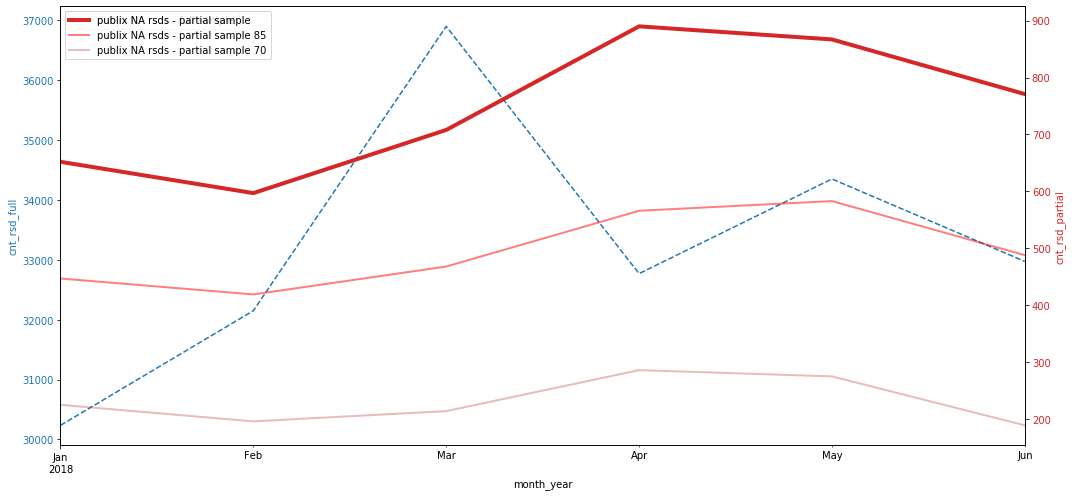

In [276]:

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('cnt_rsd_full', color=color)
ax1=allrsd.plot(legend=True,figsize=(15,7),linestyle='--',label='publix NA rsds - full sample')
ax1.legend(loc='upper left')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:red'
ax2.set_ylabel('cnt_rsd_partial', color=color2)  # we already handled the x-label with ax1
narsd_s1.plot(legend=True,figsize=(15,7),linewidth=4.0,color=color2,label='publix NA rsds - partial sample',)
narsd_s1_85.plot(legend=True,figsize=(15,7),linewidth=2.0,color='red',label='publix NA rsds - partial sample 85',alpha=0.5)
narsd_s1_70.plot(legend=True,figsize=(15,7),linewidth=2.0,color='firebrick',label='publix NA rsds - partial sample 70',alpha=0.3)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Export all linegraphs

In [277]:
narsd_s1.reset_index().to_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/output/line_'+file+ '_pub.csv')
narsd_s1_85.reset_index().to_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/output/line_'+file+ '_pub_85.csv')
narsd_s1_70.reset_index().to_csv('/Volumes/GoogleDrive/My Drive/NA attribution analysis/output/line_'+file+ '_pub_70.csv')

### appendix

In [ ]:
# stolen link: https://stackoverflow.com/questions/53103848/fuzzy-matching-two-columns-in-the-same-dataframe-using-python
def find_match(x):
#   if score_cutoff = 50 :https://stackoverflow.com/questions/32055817/python-fuzzy-matching-fuzzywuzzy-keep-only-best-match
    
    match = process.extractOne(x['RSD'], known_list, scorer=fuzz.partial_token_sort_ratio)
    return pd.Series([match[0], match[1]])

data[['this year','match_rating']] = data.dropna(subset=['Company']).apply(find_match, axis=1, result_type='expand')